# *Yale Law Journal* Gender and Keywords
This notebook explores the gender of authors in the *Yale Law Journal* and breaks down author interest by keyword (where available). 

It finds that the *Yale Law Journal* has published many more articles by men than women since 2000.

# Import the libraries
I will use BeautifulSoup to scrape info from the YLJ site, pandas to manipulate the information, and obiter to implement the WGND 2.0.

In [107]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
from obiter.wgnd import *

In [108]:
database = wgnd()

WGND 2.0 name-gender (_i.e._ No code) contains 3,491,141 unique name observations. 
This file is based on WGND 2.0 name-gender-code but it omits all known conflicting names across sources, geography and gender.

Read about the project here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/MSEGSJ

Dataset citation: Raffo, Julio, 2021, "WGND 2.0", https://doi.org/10.7910/DVN/MSEGSJ, Harvard Dataverse, V1, UNF:6:5rI3h1mXzd6zkVhHurelLw== [fileUNF]
Data downloaded


# Scraping loop

This code gets all the articles on the website and visits each individual page to retrieve the keywords, if any, that are attached to the article.

In [9]:
url = 'https://www.yalelawjournal.org/issue/issue/volume-132-issue-5-march-2023'
res = requests.get(url)
res.status_code

200

In [10]:
soup = BeautifulSoup(res.content, 'lxml')

In [93]:
df = pd.DataFrame()
idx = 0
for volume in soup.find_all('div', class_='volume_wrapper'):
    time.sleep(0.1)
    vol_num = volume.find('div', class_='volume_number').text
    for issue in volume.find_all('div', class_='issue_wrapper'):
        issue_num = issue.find('div', class_='issue_number').text
        for entry in issue.find_all('div', class_='toc_item'):
            #reset values
            entry_type = 'na'
            title = 'na'
            author = 'na'
            link = 'na'
            tags = 'na'
            pages = 'na'
            num_pages = 'na'
            
            entry_type = entry.find('h4').text
            title = entry.find('h3').text
            author = entry.find('div', class_='author').text
            link = entry.find('a')['href']
            df.loc[idx, 'volume'] = vol_num
            df.loc[idx, 'issue'] = issue_num
            df.loc[idx, 'entry_type'] = entry_type
            df.loc[idx, 'title'] = title
            df.loc[idx, 'author'] = author
            df.loc[idx, 'link'] = link
            article_html = requests.get(f'https://www.yalelawjournal.org/{link}')
            article_soup = BeautifulSoup(article_html.content, 'lxml')
            try:
                tags = article_soup.find('span', class_='tags').text
            except:
                tags = ''
            try:
                pages = article_soup.find('div', class_='issue_pages').text
                num_pages = int(pages.split('-')[1]) - int(pages.split('-')[0])
            except:
                num_pages = 'na'
            df.loc[idx, 'tags'] = tags
            df.loc[idx, 'pages'] = pages
            df.loc[idx, 'num_pages'] = num_pages
            idx += 1
            if idx % 100 == 0:
                print("Processed", idx, "loops")
            

Processed 100 loops
Processed 200 loops
Processed 300 loops
Processed 400 loops
Processed 500 loops
Processed 600 loops
Processed 700 loops
Processed 800 loops
Processed 900 loops
Processed 1000 loops
Processed 1100 loops


# Save DF to file

In [95]:
df.to_csv('yale_law_journal.csv', index=False)

In [134]:
df = pd.read_csv('yale_law_journal.csv')
df

,volume,issue,entry_type,title,author,link,tags,pages,num_pages
0,132,5,Article,Equity’s Constitutional Source,Owen W. Gallogly,/article/equitys-constitutional-source,Constitutional Law • Federal Courts • Remedies,1213-1599,386.0
1,132,5,Article,Coordinated Rulemaking and Cooperative Federal...,Bridget A. Fahey,/article/coordinated-rulemaking,Administrative Law • Federalism,1213-1599,386.0
2,132,5,Feature,After the Law of Apolitical Economy: Reclaimin...,Diana S. Reddy,/feature/after-the-law-of-apolitical-economy,Labor and Employment Law,1213-1599,386.0
3,132,5,Note,"Reviving the Prophylactic VRA: Section 3, Purc...",David Herman,/note/reviving-the-prophylactic-vra,Election Law,1213-1599,386.0
4,132,5,Note,Statutory Structure,Russell C. Bogue,/note/statutory-structure,Statutory Interpretation,1213-1599,386.0
...,...,...,...,...,...,...,...,...,...
1098,110,2,Note,The Floodgates of Strict Liability: Bursting R...,Jed Handelsman Shugerman,/note/the-floodgates-of-strict-liability-burst...,Torts • Environmental Law,-,na
1099,110,1,Essay,Deliberative Trouble? Why Groups Go to Extremes,Cass R. Sunstein,/essay/deliberative-trouble-why-groups-go-to-e...,Civil Procedure • Local Government • Constitut...,1-200,199
1100,110,1,Article,Optimal Standardization in the Law of Property...,Thomas W. Merrill & Henry E. Smith,/article/optimal-standardization-in-the-law-of...,Property,1-200,199
1101,110,1,Comment,DNA's Dark Side,Geoffrey Christopher Rapp,/comment/dnas-dark-side,Criminal Procedure,1-200,199


# Process the data
Many articles had co-authors. Because I want to examine the gender of each co-author, I need to get make a new dataframe with each co-author as a row. I do this by splitting the co-author column on the comma and then using the explode function to make each co-author a row.

In [135]:
# Use the replace() method to replace the ampersands with commas
df['author'] = df['author'].str.replace(' & ', ', ')
df['author'] = df['author'].str.replace(', Jr.', '')
df['author'] = df['author'].str.replace(', c.s.c.', '')

# Fill any missing or NaN values with an empty string
df['author'] = df['author'].fillna('')

# Add a new column that counts the number of authors in the original row
df['num_authors'] = df['author'].apply(lambda x: len(x.split(', ')))

# Use the split() method to split the "author" column into separate values
df['author'] = df['author'].str.split(', ')

# Use the explode() method to transform the list values into separate rows
df_exploded = df.explode('author')

/var/folders/54/pnyqyxcd4013kndyzbprlnxh0000gn/T/ipykernel_6351/875587416.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['author'] = df['author'].str.replace(', Jr.', '')
/var/folders/54/pnyqyxcd4013kndyzbprlnxh0000gn/T/ipykernel_6351/875587416.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['author'] = df['author'].str.replace(', c.s.c.', '')


In [136]:
df_exploded.reset_index(drop=True, inplace=True)

In [137]:
df_exploded

,volume,issue,entry_type,title,author,link,tags,pages,num_pages,num_authors
0,132,5,Article,Equity’s Constitutional Source,Owen W. Gallogly,/article/equitys-constitutional-source,Constitutional Law • Federal Courts • Remedies,1213-1599,386.0,1
1,132,5,Article,Coordinated Rulemaking and Cooperative Federal...,Bridget A. Fahey,/article/coordinated-rulemaking,Administrative Law • Federalism,1213-1599,386.0,1
2,132,5,Feature,After the Law of Apolitical Economy: Reclaimin...,Diana S. Reddy,/feature/after-the-law-of-apolitical-economy,Labor and Employment Law,1213-1599,386.0,1
3,132,5,Note,"Reviving the Prophylactic VRA: Section 3, Purc...",David Herman,/note/reviving-the-prophylactic-vra,Election Law,1213-1599,386.0,1
4,132,5,Note,Statutory Structure,Russell C. Bogue,/note/statutory-structure,Statutory Interpretation,1213-1599,386.0,1
...,...,...,...,...,...,...,...,...,...,...
1269,110,1,Essay,Deliberative Trouble? Why Groups Go to Extremes,Cass R. Sunstein,/essay/deliberative-trouble-why-groups-go-to-e...,Civil Procedure • Local Government • Constitut...,1-200,199,1
1270,110,1,Article,Optimal Standardization in the Law of Property...,Thomas W. Merrill,/article/optimal-standardization-in-the-law-of...,Property,1-200,199,2
1271,110,1,Article,Optimal Standardization in the Law of Property...,Henry E. Smith,/article/optimal-standardization-in-the-law-of...,Property,1-200,199,2
1272,110,1,Comment,DNA's Dark Side,Geoffrey Christopher Rapp,/comment/dnas-dark-side,Criminal Procedure,1-200,199,1


# Get the gender valences of each name
I implement the WGND 2.0 to check the gendered valances of each first name.

In [138]:
for idx,row in df_exploded.iterrows():
    first_name = row['author'].split(' ')[0]
    if '.' in first_name:
        first_name = row['author'].split(' ')[1]
    df_exploded.loc[idx,'gender'] = database.get_gender(first_name)
    

In [139]:
df_exploded['gender'].value_counts()

M          833
F          333
unknown    108
Name: gender, dtype: int64

<AxesSubplot: xlabel='volume'>

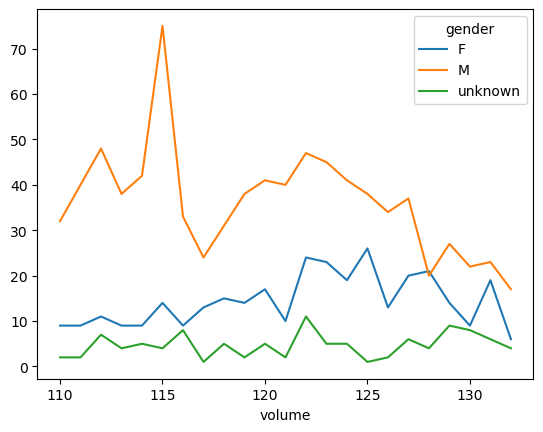

In [190]:
df_exploded.groupby(['volume', 'gender']).size().unstack().plot(kind='line')

In [191]:
with_keywords = df_exploded[~df_exploded['tags'].isna()]
with_keywords['keywords'] = with_keywords['tags'].str.split(' • ')
keywords_exploded = with_keywords.explode('keywords')
keywords_exploded['keywords'].value_counts().to_frame()


/var/folders/54/pnyqyxcd4013kndyzbprlnxh0000gn/T/ipykernel_6351/1896757331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_keywords['keywords'] = with_keywords['tags'].str.split(' • ')


,keywords
Constitutional Law,309
Criminal Procedure,97
Administrative Law,97
Antidiscrimination Law,82
Criminal Law,68
International Law,67
National Security,65
Federal Courts,65
Civil-Rights Law,63
Corporate Law,59


In [ ]:

women = keywords_exploded.groupby('gender')['keywords'].value_counts().to_frame().loc['F']
men = keywords_exploded.groupby('gender')['keywords'].value_counts().to_frame().loc['M']
women = women.rename(columns={'keywords':'num'}).reset_index()
men = men.rename(columns={'keywords':'num'}).reset_index()

# Identify the areas of law where there were more women authors associated with a keyword over men

In [189]:
for idx,row in women.iterrows():
    keyword = row['keywords']
    num = row['num']
    try:
        num_men = men[men['keywords'] == keyword]['num'].values[0]
    except:
        num_men = 0
    if num >= num_men:
        print(f'{keyword}: women {num}; men {num_men}')

Gender and Sexual Orientation: women 22; men 10
Family Law: women 13; men 6
Labor and Employment Law: women 13; men 9
Health Law: women 12; men 8
Reproductive Rights: women 9; men 6
Human Rights Law: women 7; men 6
Evidence: women 6; men 6
Federal Indian Law: women 6; men 2
Land Use: women 6; men 5
Policing: women 5; men 3
Critical Legal Studies: women 3; men 1
U.S. Territories: women 3; men 3
Media Law: women 2; men 0
Art Law: women 1; men 0
Bioethics: women 1; men 1
Experimental Jurisprudence: women 1; men 0
Infrastructure: women 1; men 0
